# Phase 2: Temporal Analysis

This notebook analyzes how individuals move between stations and calculates temporal metrics.

**Important:** Each "group" represents one individual person.

## Prerequisites:
- Complete Phase 1 (Station Detection) first
- Phase 1 outputs must exist in `../data/phase1_results/{WORKSHOP}/`

## Objectives:
- Identify distinct station visits for each individual (within 1.5σ bounding boxes)
- Calculate dwell time (how long individuals stay at each station)
- Calculate travel time between stations
- Analyze transition patterns
- Utilize point classification (at_station vs traveling)

## Constraints:
- Each person visits each station exactly **once**
- Each person is at **one station at a time**
- No two people are at the **same station simultaneously**

## Output:
- Station visits dataframe
- Travel times dataframe
- Transition matrices

## Workshop Selection

In [16]:
# ============================================
# WORKSHOP SELECTION
# ============================================
# Must match the workshop used in Phase 1
# Valid options: "Workshop1", "Workshop2", "Workshop3"

WORKSHOP = "Workshop1"  # 👈 CHANGE THIS VALUE

# ============================================

print(f"🎯 Selected Workshop: {WORKSHOP}")
print(f"{'='*50}")
print(f"Loading Phase 1 results for {WORKSHOP}...")
print(f"{'='*50}\n")

🎯 Selected Workshop: Workshop1
Loading Phase 1 results for Workshop1...



## Setup and Load Phase 1 Results

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [18]:
# Load Phase 1 results
phase1_dir = Path(f'../data/phase1_results/{WORKSHOP}')

# Check if Phase 1 results exist
if not phase1_dir.exists():
    raise FileNotFoundError(
        f"Phase 1 results not found for {WORKSHOP}.\n"
        f"Please run phase1_station_detection.ipynb first!"
    )

# Load data with station assignments
df = pd.read_csv(phase1_dir / 'data_with_stations.csv')
df['time'] = pd.to_datetime(df['time'])

# Load station centroids
station_info = pd.read_csv(phase1_dir / 'station_centroids.csv')

# Load metadata
metadata = pd.read_csv(phase1_dir / 'phase1_metadata.csv').iloc[0]

print(f"\n{'='*60}")
print(f"📊 Loaded {WORKSHOP} Phase 1 Results")
print(f"{'='*60}")
print(f"Data points: {len(df):,}")
print(f"Number of stations: {metadata['optimal_k']}")
print(f"Groups: {sorted(df['name'].unique())}")
print(f"{'='*60}\n")

df.head()


📊 Loaded Workshop1 Phase 1 Results
Data points: 19,905
Number of stations: 5
Groups: ['Group 1', 'Group 2', 'Group 3', 'Group 5', 'Group 6', 'group 4']



,name,x,y,z,time,station,at_station,point_type
0,Group 1,40.61,13.18,-3.28,2025-07-11 12:50:27.682198,1,False,traveling
1,Group 1,40.62,13.12,-3.36,2025-07-11 12:50:28.450802,1,False,traveling
2,Group 1,40.62,13.21,-3.43,2025-07-11 12:50:29.450425,1,False,traveling
3,Group 1,40.79,13.22,-3.35,2025-07-11 12:50:30.450321,1,False,traveling
4,Group 1,40.78,13.23,-3.27,2025-07-11 12:50:31.450763,1,False,traveling


In [19]:
# Analyze point classification from Phase 1
print(f"\n{'='*60}")

# Check if metadata contains sigma_multiplier info
if (phase1_dir / 'phase1_metadata.csv').exists():
    metadata_full = pd.read_csv(phase1_dir / 'phase1_metadata.csv').iloc[0]
    sigma_used = metadata_full.get('sigma_multiplier', 1.5)
else:
    sigma_used = 1.5  # Default

print(f"📍 Point Classification ({sigma_used}σ Bounding Box Method)")
print(f"{'='*60}")

if 'at_station' in df.columns and 'point_type' in df.columns:
    at_station_count = df['at_station'].sum()
    traveling_count = (~df['at_station']).sum()
    
    print(f"Points at stations: {at_station_count:,} ({at_station_count/len(df)*100:.1f}%)")
    print(f"Traveling points: {traveling_count:,} ({traveling_count/len(df)*100:.1f}%)")
    
    print(f"\nBreakdown by group:")
    for group in sorted(df['name'].unique()):
        group_df = df[df['name'] == group]
        group_at_station = group_df['at_station'].sum()
        print(f"  {group}: {group_at_station:,} at station, "
              f"{len(group_df) - group_at_station:,} traveling")
else:
    print("⚠️  Point classification not found. Re-run Phase 1 with latest version.")
    
print(f"{'='*60}\n")


📍 Point Classification (1.5σ Bounding Box Method)
Points at stations: 16,619 (83.5%)
Traveling points: 3,286 (16.5%)

Breakdown by group:
  Group 1: 2,747 at station, 641 traveling
  Group 2: 4,377 at station, 706 traveling
  Group 3: 5,141 at station, 217 traveling
  Group 5: 2,263 at station, 460 traveling
  Group 6: 1,741 at station, 464 traveling
  group 4: 350 at station, 798 traveling



## 2.1 Identify Station Visits

**Key Constraints:** 
- Each person (group) visits each station exactly **once**
- Each person is at **one station at a time** (no overlapping visits)
- No two people occupy the **same station simultaneously**
- Travel happens **forward in time** only (chronological order)

We aggregate all data points at a given station for each person, using both temporal and positional information. This means if a person's data shows multiple time points at the same station, they all belong to the same single visit.

In [20]:
# Identify station visits for each group
# CONSTRAINT: Each group visits each station exactly once
# We aggregate all time points at a station for each group
def identify_visits(group_df):
    """
    Identify distinct station visits for a group.
    Since each group visits each station only once, we aggregate all points
    at the same station together, using temporal and positional information.
    """
    visits = []
    
    if len(group_df) == 0:
        return []
    
    # Group by station - each group visits each station only once
    for station, station_data in group_df.groupby('station'):
        visits.append({
            'station': station,
            'start_time': station_data['time'].min(),
            'end_time': station_data['time'].max(),
            'duration_seconds': (station_data['time'].max() - station_data['time'].min()).total_seconds(),
            'num_points': len(station_data),
            'avg_x': station_data['x'].mean(),
            'avg_y': station_data['y'].mean(),
            'avg_z': station_data['z'].mean()
        })
    
    # Sort visits by start time to get chronological order
    visits = sorted(visits, key=lambda x: x['start_time'])
    
    # Add visit_id based on chronological order
    for visit_id, visit in enumerate(visits):
        visit['visit_id'] = visit_id
    
    return visits

# Apply to each group
all_visits = []

for group_name, group_df in df.groupby('name'):
    visits = identify_visits(group_df)
    for visit in visits:
        visit['group'] = group_name
        all_visits.append(visit)

visits_df = pd.DataFrame(all_visits)
visits_df['duration_minutes'] = visits_df['duration_seconds'] / 60

# Sort by group and start time for better readability
visits_df = visits_df.sort_values(['group', 'start_time']).reset_index(drop=True)

print(f"Total station visits identified: {len(visits_df)}")
print(f"\nVisits per group:")
print(visits_df.groupby('group').size())
print(f"\nUnique stations visited per group:")
print(visits_df.groupby('group')['station'].nunique())
print(f"\nVerifying constraint - Groups visiting same station multiple times:")
duplicate_visits = visits_df.groupby(['group', 'station']).size()
if (duplicate_visits > 1).any():
    print("⚠️  WARNING: Some groups visit the same station multiple times!")
    print(duplicate_visits[duplicate_visits > 1])
else:
    print("✅ Constraint verified: Each group visits each station exactly once")

visits_df.head(10)

Total station visits identified: 30

Visits per group:
group
Group 1    5
Group 2    5
Group 3    5
Group 5    5
Group 6    5
group 4    5
dtype: int64

Unique stations visited per group:
group
Group 1    5
Group 2    5
Group 3    5
Group 5    5
Group 6    5
group 4    5
Name: station, dtype: int64

Verifying constraint - Groups visiting same station multiple times:
✅ Constraint verified: Each group visits each station exactly once


,station,start_time,end_time,duration_seconds,num_points,avg_x,avg_y,avg_z,visit_id,group,duration_minutes
0,1,2025-07-11 12:50:27.682198,2025-07-11 14:09:22.451421,4734.769223,591,41.365821,15.233333,-1.723503,0,Group 1,78.912820
1,4,2025-07-11 12:51:42.450087,2025-07-11 14:52:54.449464,7271.999377,1234,40.158914,9.467601,-0.593541,1,Group 1,121.199990
2,0,2025-07-11 13:06:17.450770,2025-07-11 14:28:01.450271,4903.999501,10,31.312000,9.129000,-0.778000,2,Group 1,81.733325
3,3,2025-07-11 13:06:23.451192,2025-07-11 14:28:03.450581,4899.999389,876,35.784463,13.415890,0.401918,3,Group 1,81.666656
4,2,2025-07-11 13:07:33.451052,2025-07-11 13:49:40.452415,2527.001363,677,32.671108,17.386484,1.976780,4,Group 1,42.116689
5,1,2025-07-11 12:50:27.638431,2025-07-11 13:50:10.753311,3583.114880,1171,40.652092,14.697319,-1.120726,0,Group 2,59.718581
6,4,2025-07-11 12:51:19.949858,2025-07-11 14:20:06.250861,5326.301003,1223,38.536778,9.360662,-3.483851,1,Group 2,88.771683
7,0,2025-07-11 13:05:37.951182,2025-07-11 15:29:57.750759,8659.799577,200,30.198700,7.071450,0.132800,2,Group 2,144.329993
8,2,2025-07-11 13:06:24.950934,2025-07-11 15:29:37.750128,8592.799194,1489,33.626051,18.308126,-0.884412,3,Group 2,143.213320
9,3,2025-07-11 13:29:49.257871,2025-07-11 15:29:46.750052,7197.492181,1000,36.197200,13.100660,-0.833990,4,Group 2,119.958203


## 2.1.1 Validate Individual Constraints

Since each group represents one individual person, we verify:
- Each person is only at one station at any given time
- No two people are at the same station simultaneously

In [21]:
# Validate individual person constraints
print("=" * 70)
print("VALIDATING INDIVIDUAL PERSON CONSTRAINTS")
print("=" * 70)

# Check 1: Each person at only one station at a time (no overlapping visits)
print("\n1️⃣ Checking: Each person at only one station at a time")
overlapping_issues = []

for group in sorted(visits_df['group'].unique()):
    group_visits = visits_df[visits_df['group'] == group].sort_values('start_time')
    
    for i in range(len(group_visits) - 1):
        current = group_visits.iloc[i]
        next_visit = group_visits.iloc[i + 1]
        
        # Check if visits overlap in time
        if current['end_time'] > next_visit['start_time']:
            overlapping_issues.append({
                'person': group,
                'station_1': current['station'],
                'station_2': next_visit['station'],
                'overlap_start': next_visit['start_time'],
                'overlap_end': current['end_time']
            })

if overlapping_issues:
    print(f"   ⚠️  Found {len(overlapping_issues)} overlapping visits!")
    for issue in overlapping_issues[:5]:  # Show first 5
        print(f"      {issue['person']}: At stations {issue['station_1']} and {issue['station_2']} simultaneously")
else:
    print(f"   ✅ All individuals are at only one station at a time")

# Check 2: No two people at the same station simultaneously
print("\n2️⃣ Checking: No two people at the same station at the same time")
concurrent_occupancy = []

# For each station, check if multiple people are there at the same time
for station in sorted(visits_df['station'].unique()):
    station_visits = visits_df[visits_df['station'] == station].sort_values('start_time')
    
    for i in range(len(station_visits)):
        for j in range(i + 1, len(station_visits)):
            visit_i = station_visits.iloc[i]
            visit_j = station_visits.iloc[j]
            
            # Check if time ranges overlap
            if visit_i['end_time'] > visit_j['start_time'] and visit_j['end_time'] > visit_i['start_time']:
                concurrent_occupancy.append({
                    'station': station,
                    'person_1': visit_i['group'],
                    'person_2': visit_j['group'],
                    'overlap_start': max(visit_i['start_time'], visit_j['start_time']),
                    'overlap_end': min(visit_i['end_time'], visit_j['end_time'])
                })

if concurrent_occupancy:
    print(f"   ⚠️  Found {len(concurrent_occupancy)} instances of concurrent occupancy!")
    station_conflicts = {}
    for issue in concurrent_occupancy:
        station_conflicts.setdefault(issue['station'], []).append(
            f"{issue['person_1']} & {issue['person_2']}"
        )
    
    for station, conflicts in sorted(station_conflicts.items())[:5]:  # Show first 5 stations
        print(f"      Station {station}: {len(conflicts)} conflicts ({conflicts[0]})")
else:
    print(f"   ✅ Each station is occupied by only one person at a time")

# Summary
print("\n" + "=" * 70)
if not overlapping_issues and not concurrent_occupancy:
    print("✅ ALL CONSTRAINTS SATISFIED:")
    print("   • Each person is at one station at a time")
    print("   • Each station has one person at a time")
else:
    print("⚠️  CONSTRAINT VIOLATIONS DETECTED:")
    if overlapping_issues:
        print(f"   • {len(overlapping_issues)} people at multiple stations simultaneously")
    if concurrent_occupancy:
        print(f"   • {len(concurrent_occupancy)} instances of multiple people at same station")
    print("\n💡 This may be due to:")
    print("   - Overlapping station bounding boxes (adjust σ in Phase 1)")
    print("   - Data collection timing/precision issues")
    print("   - People actually being in transition between stations")
print("=" * 70 + "\n")

VALIDATING INDIVIDUAL PERSON CONSTRAINTS

1️⃣ Checking: Each person at only one station at a time
   ⚠️  Found 23 overlapping visits!
      Group 1: At stations 1 and 4 simultaneously
      Group 1: At stations 4 and 0 simultaneously
      Group 1: At stations 0 and 3 simultaneously
      Group 1: At stations 3 and 2 simultaneously
      Group 2: At stations 1 and 4 simultaneously

2️⃣ Checking: No two people at the same station at the same time
   ⚠️  Found 69 instances of concurrent occupancy!
      Station 0: 15 conflicts (Group 2 & Group 3)
      Station 1: 15 conflicts (Group 3 & Group 2)
      Station 2: 11 conflicts (Group 3 & Group 2)
      Station 3: 13 conflicts (Group 3 & Group 1)
      Station 4: 15 conflicts (Group 2 & Group 1)

⚠️  CONSTRAINT VIOLATIONS DETECTED:
   • 23 people at multiple stations simultaneously
   • 69 instances of multiple people at same station

💡 This may be due to:
   - Overlapping station bounding boxes (adjust σ in Phase 1)
   - Data collection ti

## 2.2 Calculate Dwell Time per Station

Dwell Time Statistics by Station:
         Mean (min)  Median (min)  Std Dev  Min (min)  Max (min)  Visit Count
station                                                                      
0            109.18        112.66    46.69      42.41     161.30            6
1            100.20         98.65    48.24      39.42     158.34            6
2             72.80         45.06    55.54      19.45     143.62            6
3             82.43         77.21    41.23      23.44     137.17            6
4            121.94        132.76    39.32      62.12     159.19            6


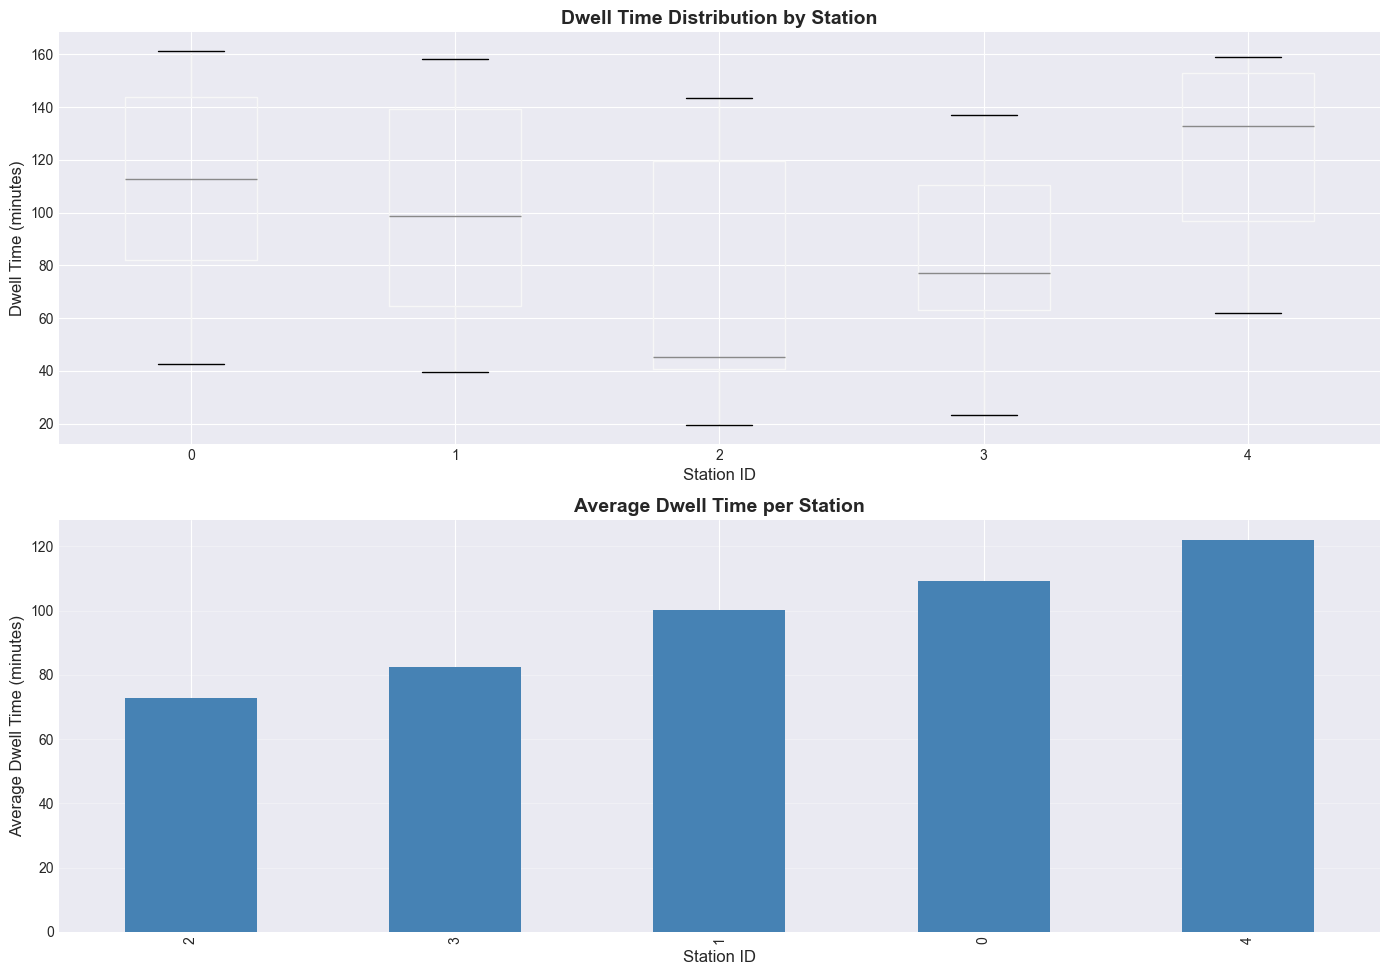

In [22]:
# Analyze dwell time at each station
dwell_stats = visits_df.groupby('station').agg({
    'duration_minutes': ['mean', 'median', 'std', 'min', 'max', 'count']
}).round(2)

dwell_stats.columns = ['Mean (min)', 'Median (min)', 'Std Dev', 'Min (min)', 'Max (min)', 'Visit Count']

print("Dwell Time Statistics by Station:")
print(dwell_stats)

# Visualize dwell time distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Box plot
visits_df.boxplot(column='duration_minutes', by='station', ax=axes[0])
axes[0].set_title('Dwell Time Distribution by Station', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Station ID', fontsize=12)
axes[0].set_ylabel('Dwell Time (minutes)', fontsize=12)
axes[0].get_figure().suptitle('')  # Remove default title

# Bar plot of mean dwell time
mean_dwell = visits_df.groupby('station')['duration_minutes'].mean().sort_values()
mean_dwell.plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Average Dwell Time per Station', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Station ID', fontsize=12)
axes[1].set_ylabel('Average Dwell Time (minutes)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 2.3 Calculate Travel Time Between Stations

In [23]:
# Calculate travel time between consecutive stations
# CONSTRAINT: Travel only happens forward in time (no negative travel times)
travel_times = []
negative_travel_times = []

for group, group_visits in visits_df.groupby('group'):
    group_visits = group_visits.sort_values('start_time')
    
    for i in range(len(group_visits) - 1):
        current_visit = group_visits.iloc[i]
        next_visit = group_visits.iloc[i + 1]
        
        travel_time_seconds = (next_visit['start_time'] - current_visit['end_time']).total_seconds()
        
        # Only include forward travel (positive or zero time)
        if travel_time_seconds >= 0:
            travel_times.append({
                'group': group,
                'from_station': current_visit['station'],
                'to_station': next_visit['station'],
                'travel_time_seconds': travel_time_seconds,
                'travel_time_minutes': travel_time_seconds / 60,
                'departure_time': current_visit['end_time'],
                'arrival_time': next_visit['start_time']
            })
        else:
            # Track negative travel times for reporting
            negative_travel_times.append({
                'group': group,
                'from_station': current_visit['station'],
                'to_station': next_visit['station'],
                'travel_time_minutes': travel_time_seconds / 60,
                'current_end': current_visit['end_time'],
                'next_start': next_visit['start_time']
            })

travel_df = pd.DataFrame(travel_times)

print(f"Total station transitions: {len(travel_df)}")
print(f"\nTravel Time Summary:")
print(travel_df['travel_time_minutes'].describe())

# Report any negative travel times that were filtered out
if negative_travel_times:
    print(f"\n⚠️  WARNING: {len(negative_travel_times)} negative travel times detected and excluded!")
    print(f"   This indicates overlapping station visits (next station started before previous ended)")
    print(f"\n   Details of excluded transitions:")
    neg_df = pd.DataFrame(negative_travel_times)
    for idx, row in neg_df.iterrows():
        print(f"     {row['group']}: Station {row['from_station']} → {row['to_station']}: "
              f"{row['travel_time_minutes']:.1f} min (overlap)")
    print(f"\n   💡 This is normal if station bounding boxes overlap or data collection is imprecise")
else:
    print(f"\n✅ All travel times are forward in time (no negative values)")

travel_df.head(10)

Total station transitions: 1

Travel Time Summary:
count     1.000000
mean     13.916783
std            NaN
min      13.916783
25%      13.916783
50%      13.916783
75%      13.916783
max      13.916783
Name: travel_time_minutes, dtype: float64

⚠️  WARNING: 23 negative travel times detected and excluded!
   This indicates overlapping station visits (next station started before previous ended)

   Details of excluded transitions:
     Group 1: Station 1 → 4: -77.7 min (overlap)
     Group 1: Station 4 → 0: -106.6 min (overlap)
     Group 1: Station 0 → 3: -81.6 min (overlap)
     Group 1: Station 3 → 2: -80.5 min (overlap)
     Group 2: Station 1 → 4: -58.8 min (overlap)
     Group 2: Station 4 → 0: -74.5 min (overlap)
     Group 2: Station 0 → 2: -143.5 min (overlap)
     Group 2: Station 2 → 3: -119.8 min (overlap)
     Group 3: Station 1 → 4: -37.0 min (overlap)
     Group 3: Station 4 → 3: -61.9 min (overlap)
     Group 3: Station 3 → 0: -124.1 min (overlap)
     Group 3: Station 0

,group,from_station,to_station,travel_time_seconds,travel_time_minutes,departure_time,arrival_time
0,Group 5,3,2,835.007001,13.916783,2025-07-11 14:16:18.650659,2025-07-11 14:30:13.657660


## 2.4 Travel Times by Group

In [24]:
# Analyze travel times for each group individually
print("=" * 70)
print("TRAVEL TIMES BY GROUP")
print("=" * 70)

for group in sorted(travel_df['group'].unique()):
    group_travel = travel_df[travel_df['group'] == group].sort_values('departure_time')
    
    print(f"\n📍 {group}")
    print(f"{'─' * 70}")
    print(f"  Total transitions: {len(group_travel)}")
    print(f"  Average travel time: {group_travel['travel_time_minutes'].mean():.1f} minutes")
    print(f"  Median travel time: {group_travel['travel_time_minutes'].median():.1f} minutes")
    print(f"  Min travel time: {group_travel['travel_time_minutes'].min():.1f} minutes")
    print(f"  Max travel time: {group_travel['travel_time_minutes'].max():.1f} minutes")
    
    print(f"\n  Journey sequence:")
    for idx, row in group_travel.iterrows():
        print(f"    Station {row['from_station']:2d} → Station {row['to_station']:2d}: "
              f"{row['travel_time_minutes']:6.1f} min "
              f"(departed: {row['departure_time'].strftime('%H:%M:%S')})")

print("\n" + "=" * 70)

TRAVEL TIMES BY GROUP

📍 Group 5
──────────────────────────────────────────────────────────────────────
  Total transitions: 1
  Average travel time: 13.9 minutes
  Median travel time: 13.9 minutes
  Min travel time: 13.9 minutes
  Max travel time: 13.9 minutes

  Journey sequence:
    Station  3 → Station  2:   13.9 min (departed: 14:16:18)



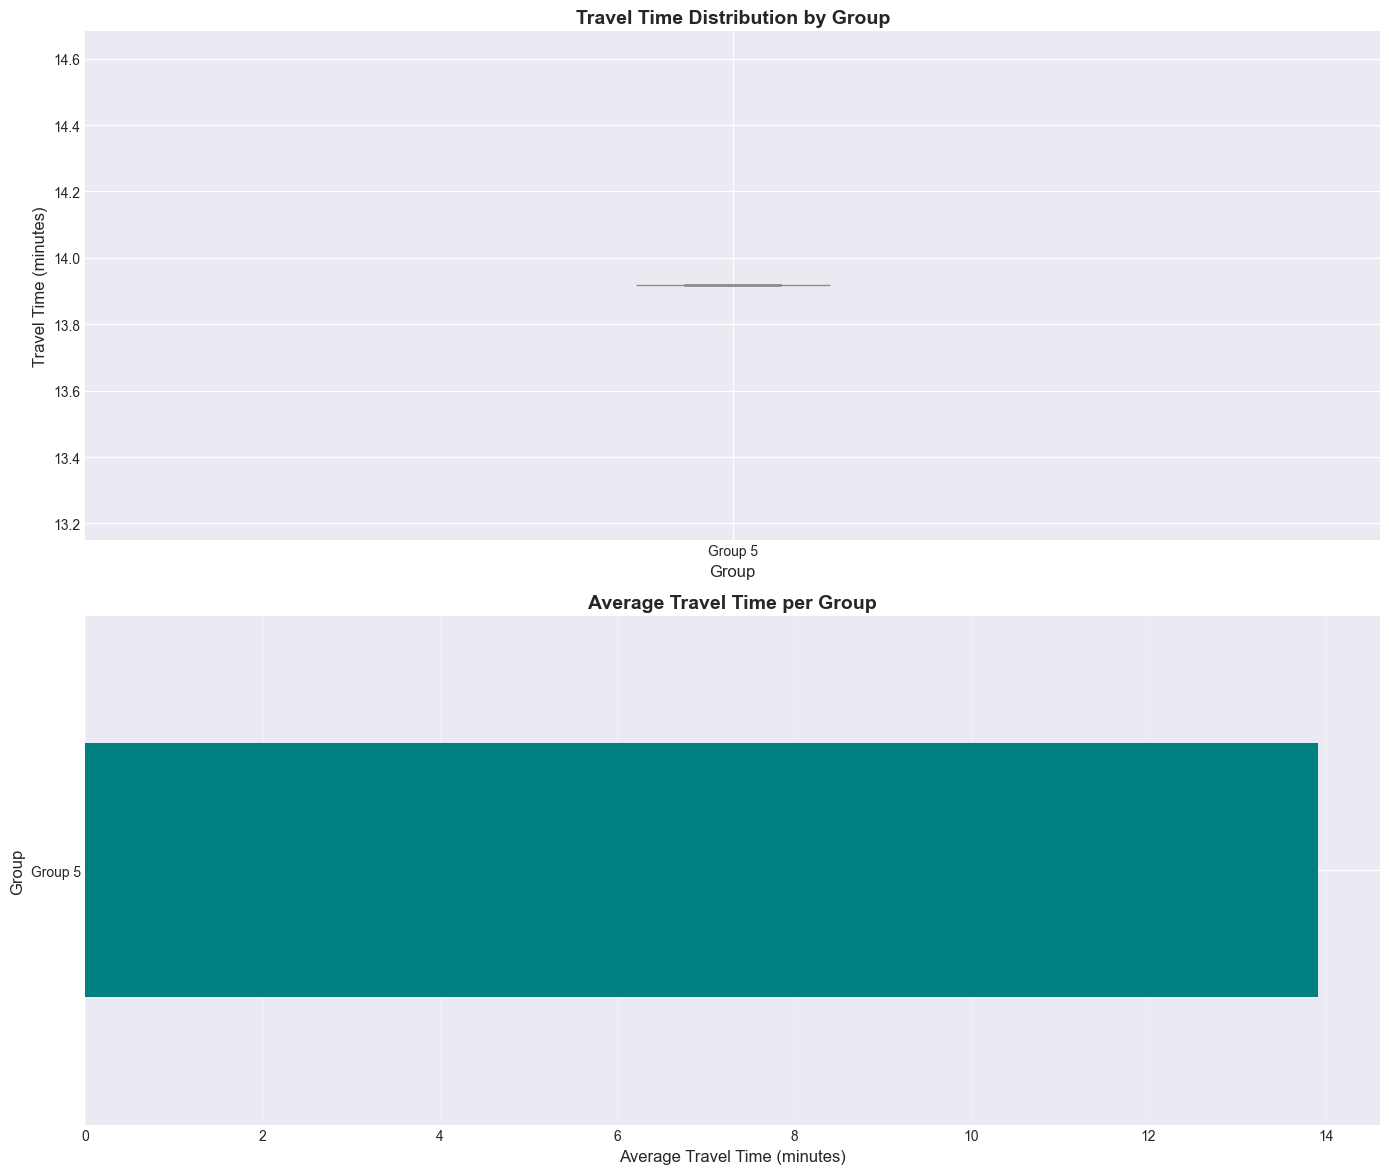


Travel Time Statistics by Group:
         Mean (min)  Median (min)  Std Dev  Min (min)  Max (min)  Transitions
group                                                                        
Group 5       13.92         13.92      NaN      13.92      13.92            1


In [25]:
# Visualize travel time comparison across groups
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Box plot: Travel time distribution by group
travel_df.boxplot(column='travel_time_minutes', by='group', ax=axes[0])
axes[0].set_title('Travel Time Distribution by Group', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Group', fontsize=12)
axes[0].set_ylabel('Travel Time (minutes)', fontsize=12)
axes[0].get_figure().suptitle('')  # Remove default title

# Bar plot: Average travel time per group
avg_travel_by_group = travel_df.groupby('group')['travel_time_minutes'].mean().sort_values()
avg_travel_by_group.plot(kind='barh', ax=axes[1], color='teal')
axes[1].set_title('Average Travel Time per Group', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Travel Time (minutes)', fontsize=12)
axes[1].set_ylabel('Group', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Summary statistics by group
print("\nTravel Time Statistics by Group:")
group_travel_stats = travel_df.groupby('group')['travel_time_minutes'].agg([
    ('Mean (min)', 'mean'),
    ('Median (min)', 'median'),
    ('Std Dev', 'std'),
    ('Min (min)', 'min'),
    ('Max (min)', 'max'),
    ('Transitions', 'count')
]).round(2)
print(group_travel_stats)

In [26]:
# Validate temporal consistency - ensure all movements are forward in time
print("\n" + "=" * 70)
print("TEMPORAL CONSISTENCY VALIDATION")
print("=" * 70)

# Check that all travel times are non-negative
if len(travel_df) > 0:
    min_travel_time = travel_df['travel_time_minutes'].min()
    max_travel_time = travel_df['travel_time_minutes'].max()
    
    print(f"\n✅ All travel times are forward in time")
    print(f"   Minimum travel time: {min_travel_time:.2f} minutes")
    print(f"   Maximum travel time: {max_travel_time:.2f} minutes")
    
    # Check for suspicious zero or near-zero travel times
    zero_travel = travel_df[travel_df['travel_time_minutes'] < 0.1]
    if len(zero_travel) > 0:
        print(f"\n💡 Found {len(zero_travel)} transitions with near-zero travel time (<0.1 min)")
        print(f"   This may indicate overlapping or adjacent station boundaries")

# Verify chronological order within each group
print(f"\nVerifying chronological order per group:")
for group in sorted(travel_df['group'].unique()):
    group_travel = travel_df[travel_df['group'] == group].sort_values('departure_time')
    times_ordered = (group_travel['arrival_time'] >= group_travel['departure_time']).all()
    sequential = True
    
    # Check that each arrival is before or equal to next departure
    for i in range(len(group_travel) - 1):
        if group_travel.iloc[i+1]['departure_time'] < group_travel.iloc[i]['arrival_time']:
            sequential = False
            break
    
    status = "✅" if times_ordered and sequential else "⚠️"
    print(f"  {status} {group}: Chronologically ordered")

print("=" * 70 + "\n")


TEMPORAL CONSISTENCY VALIDATION

✅ All travel times are forward in time
   Minimum travel time: 13.92 minutes
   Maximum travel time: 13.92 minutes

Verifying chronological order per group:
  ✅ Group 5: Chronologically ordered



Average Travel Time Matrix (minutes):
to_station        2
from_station       
3             13.92


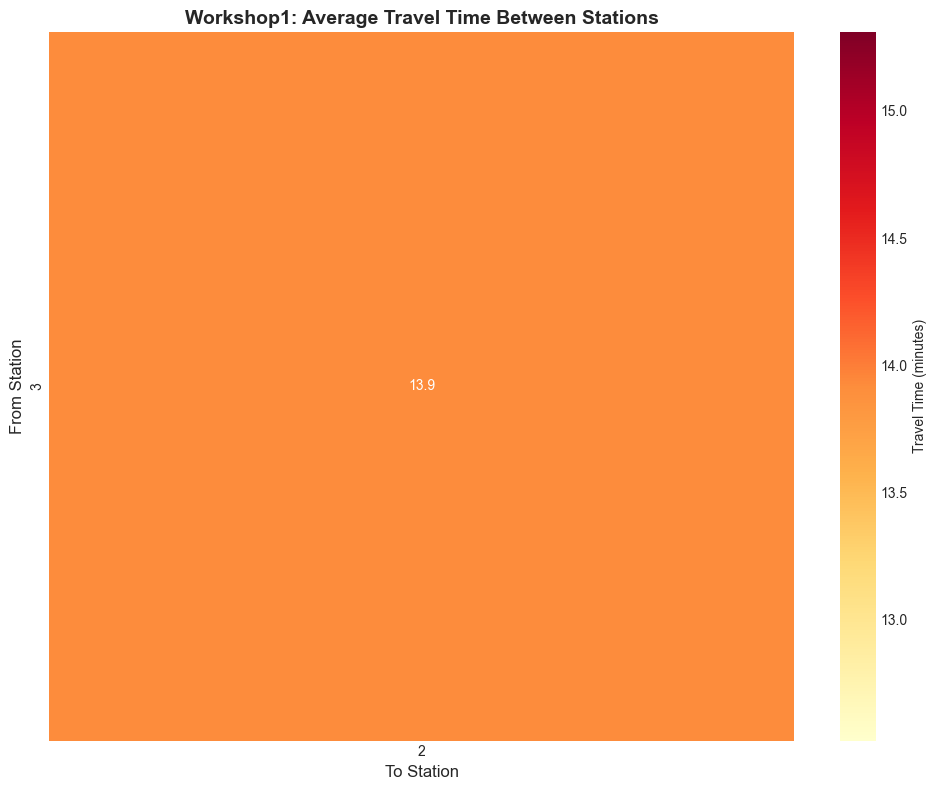

In [27]:
# Create transition matrix (average travel time between stations)
transition_matrix = travel_df.groupby(['from_station', 'to_station'])['travel_time_minutes'].mean().unstack(fill_value=0)

print("Average Travel Time Matrix (minutes):")
print(transition_matrix.round(2))

# Visualize transition matrix
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Travel Time (minutes)'})
plt.title(f'{WORKSHOP}: Average Travel Time Between Stations', fontsize=14, fontweight='bold')
plt.xlabel('To Station', fontsize=12)
plt.ylabel('From Station', fontsize=12)
plt.tight_layout()
plt.show()

Most Common Station Transitions:
from_station  to_station
3             2             1
dtype: int64


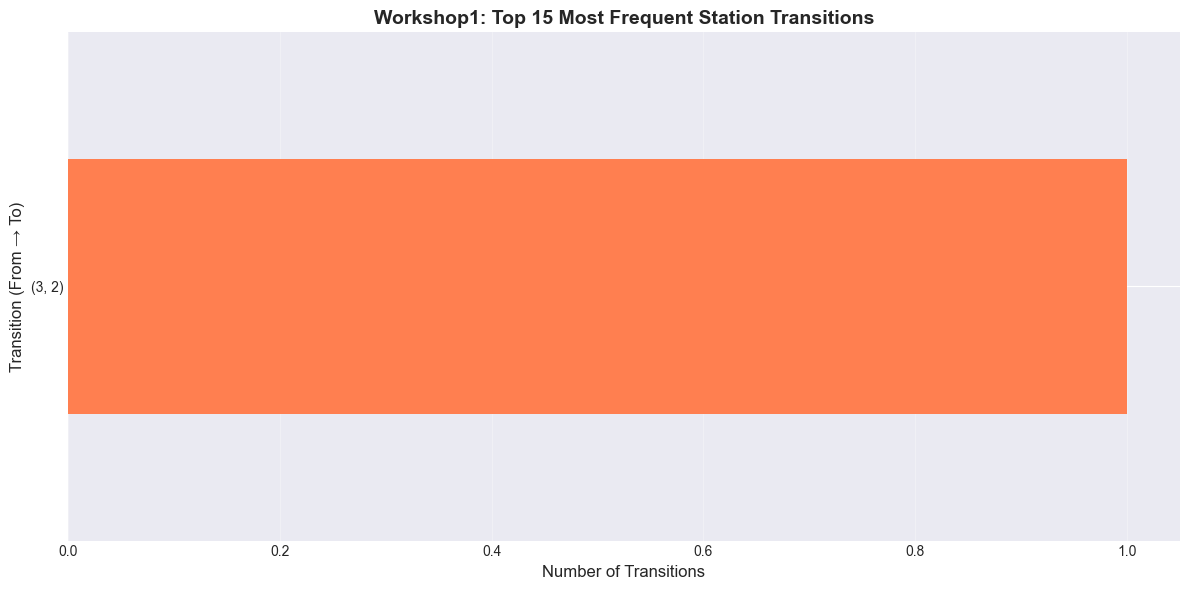

In [28]:
# Analyze most common transitions
transition_counts = travel_df.groupby(['from_station', 'to_station']).size().sort_values(ascending=False)

print("Most Common Station Transitions:")
print(transition_counts.head(10))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
transition_counts.head(15).plot(kind='barh', ax=ax, color='coral')
ax.set_title(f'{WORKSHOP}: Top 15 Most Frequent Station Transitions', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Transitions', fontsize=12)
ax.set_ylabel('Transition (From → To)', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Summary Statistics

In [29]:
print("=" * 70)
print(f"PHASE 2 TEMPORAL ANALYSIS SUMMARY - {WORKSHOP}")
print("=" * 70)

print(f"\n📊 Station Visits")
print(f"  • Total visits: {len(visits_df)}")
print(f"  • Average visit duration: {visits_df['duration_minutes'].mean():.1f} minutes")
print(f"  • Median visit duration: {visits_df['duration_minutes'].median():.1f} minutes")
print(f"  • Most visited station: {visits_df['station'].mode().values[0]}")

print(f"\n🚶 Station Transitions (Forward Time Only)")
print(f"  • Total transitions: {len(travel_df)}")
print(f"  • Average travel time: {travel_df['travel_time_minutes'].mean():.1f} minutes")
print(f"  • Median travel time: {travel_df['travel_time_minutes'].median():.1f} minutes")
if len(travel_df) > 0:
    print(f"  • Min travel time: {travel_df['travel_time_minutes'].min():.1f} minutes")
    print(f"  • Max travel time: {travel_df['travel_time_minutes'].max():.1f} minutes")

print(f"\n📍 Per-Station Summary")
for station in sorted(visits_df['station'].unique()):
    station_visits = visits_df[visits_df['station'] == station]
    print(f"  Station {station}:")
    print(f"    - Visits: {len(station_visits)}")
    print(f"    - Avg dwell time: {station_visits['duration_minutes'].mean():.1f} min")

print("\n" + "=" * 70)

PHASE 2 TEMPORAL ANALYSIS SUMMARY - Workshop1

📊 Station Visits
  • Total visits: 30
  • Average visit duration: 97.3 minutes
  • Median visit duration: 86.1 minutes
  • Most visited station: 0

🚶 Station Transitions (Forward Time Only)
  • Total transitions: 1
  • Average travel time: 13.9 minutes
  • Median travel time: 13.9 minutes
  • Min travel time: 13.9 minutes
  • Max travel time: 13.9 minutes

📍 Per-Station Summary
  Station 0:
    - Visits: 6
    - Avg dwell time: 109.2 min
  Station 1:
    - Visits: 6
    - Avg dwell time: 100.2 min
  Station 2:
    - Visits: 6
    - Avg dwell time: 72.8 min
  Station 3:
    - Visits: 6
    - Avg dwell time: 82.4 min
  Station 4:
    - Visits: 6
    - Avg dwell time: 121.9 min



## Save Phase 2 Results

In [30]:
# Create output directory
output_dir = Path(f'../data/phase2_results/{WORKSHOP}')
output_dir.mkdir(parents=True, exist_ok=True)

# Save visits data
visits_df.to_csv(output_dir / 'station_visits.csv', index=False)

# Save travel times (includes group information)
travel_df.to_csv(output_dir / 'travel_times.csv', index=False)

# Save travel times by group (separate file for each group)
for group in sorted(travel_df['group'].unique()):
    group_travel = travel_df[travel_df['group'] == group].sort_values('departure_time')
    group_travel.to_csv(output_dir / f'travel_times_{group}.csv', index=False)

# Save transition matrix
transition_matrix.to_csv(output_dir / 'transition_matrix.csv')

# Save dwell statistics
dwell_stats.to_csv(output_dir / 'dwell_statistics.csv')

# Save group-specific travel statistics
group_travel_stats = travel_df.groupby('group')['travel_time_minutes'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(2)
group_travel_stats.to_csv(output_dir / 'travel_statistics_by_group.csv')

# Save summary statistics
summary_stats = {
    'workshop': WORKSHOP,
    'total_visits': len(visits_df),
    'avg_dwell_time_min': visits_df['duration_minutes'].mean(),
    'median_dwell_time_min': visits_df['duration_minutes'].median(),
    'total_transitions': len(travel_df),
    'avg_travel_time_min': travel_df['travel_time_minutes'].mean(),
    'median_travel_time_min': travel_df['travel_time_minutes'].median()
}
pd.DataFrame([summary_stats]).to_csv(output_dir / 'phase2_summary.csv', index=False)

print(f"✅ Phase 2 results saved to {output_dir}/")
print(f"\nSaved files:")
print(f"  • station_visits.csv - All station visits with durations")
print(f"  • travel_times.csv - All travel times (includes group column)")
print(f"  • travel_times_<group>.csv - Individual files per group")
print(f"  • travel_statistics_by_group.csv - Summary stats per group")
print(f"  • transition_matrix.csv - Avg travel time matrix")
print(f"  • dwell_statistics.csv - Per-station dwell statistics")
print(f"  • phase2_summary.csv - Overall summary statistics")
print(f"\n🎯 Proceed to phase3_predictive_modeling.ipynb")

✅ Phase 2 results saved to ../data/phase2_results/Workshop1/

Saved files:
  • station_visits.csv - All station visits with durations
  • travel_times.csv - All travel times (includes group column)
  • travel_times_<group>.csv - Individual files per group
  • travel_statistics_by_group.csv - Summary stats per group
  • transition_matrix.csv - Avg travel time matrix
  • dwell_statistics.csv - Per-station dwell statistics
  • phase2_summary.csv - Overall summary statistics

🎯 Proceed to phase3_predictive_modeling.ipynb
